In [1]:
############# LOAD LIBRARIES #############
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import random 
from PIL import Image
from keras.utils import Progbar
from timeit import default_timer as timer

######## INITIALIZE DATASET DIRECTORIES ########
DATASET_NAME = ''
DATASET_DIR = "../datasets/" + DATASET_NAME
TRAIN_DIR = DATASET_DIR + 'CoILTrain'
VAL_DIR = DATASET_DIR + 'CoILVal1'
TEST_DIR = DATASET_DIR + 'CoILVal2'
TOWN3_DIR = DATASET_DIR + 'CoILTrainTown03'

Using TensorFlow backend.


In [2]:
######## CHECK AVAILABLE DATA ########
episode_list = []
directories = [TRAIN_DIR, VAL_DIR, TEST_DIR]
for directory in directories:
    for item in os.listdir(directory):
        if 'episode' in item:
            #print(item, len(os.listdir(TRAIN_DIR + '/' + item)))
            episode_list.append(directory + '/' + item)
        elif 'metadata' in item:
            with open(directory + '/' + item) as f:
                metadata = json.loads(f.read())
print("Total Episodes:", len(episode_list))
episode_list[:5]

Total Episodes: 42


['../datasets/CoILTrain/episode_00003',
 '../datasets/CoILTrain/episode_00018',
 '../datasets/CoILTrain/episode_00012',
 '../datasets/CoILTrain/episode_00000',
 '../datasets/CoILTrain/episode_00010']

In [3]:
######## FIND IMAGE AND JSON DATA FILES ########
x_data_files, y_data_files = [], []
camera_text = 'CentralRGB_'
measurement_text = 'measurements'
for ep in episode_list:
    files = os.listdir(ep)
    for file in files:
        if camera_text in file:
            x_data_files.append(ep + '/' + file)
        if measurement_text in file:
            y_data_files.append(ep + '/' + file)
            
x_data_files = sorted(x_data_files)
y_data_files = sorted(y_data_files)

print("X length:", len(x_data_files), "| Sample:", x_data_files[0])
print("Y length:", len(y_data_files), "| Sample:", y_data_files[0])

if len(x_data_files) != len(y_data_files):
    print("Warning: X and Y data files do not have the same length. Please fix it before proceeding!")

X length: 77107 | Sample: ../datasets/CoILTrain/episode_00000/CentralRGB_00000.png
Y length: 77107 | Sample: ../datasets/CoILTrain/episode_00000/measurements_00000.json


In [4]:
################## PROCESSING INPUT DATA ######################
FRAME_BATCH = 6  # number of frames and respective data is clumped together
N = len(x_data_files) - len(x_data_files) % FRAME_BATCH # get rid of extra data that doesn't fit in batch
x_data_camera = np.zeros((N, 88, 200, 3)).astype('uint8')
x_data_speed = np.zeros(N)
x_data_direction = np.zeros(N)
    
y_steer    = np.zeros(N)
y_throttle = np.zeros(N)
y_brake    = np.zeros(N)

stop_pedestrian = np.zeros(N)
stop_traffic_lights = np.zeros(N)
stop_vehicle = np.zeros(N)

pos_x = np.zeros(N)
pos_y = np.zeros(N)
pos_z = np.zeros(N)

print("Extracting images ...")
start = timer()
progbar = Progbar(target=N, verbose=1)
for index, image in enumerate(x_data_files):
    if index < N:
        x_data_camera[index] = np.array(Image.open(image)).astype('uint8')
        progbar.update(index)
    else:
        break
end = timer()
print("\nExtracted images (in {:.2f} seconds).".format(end-start))    

print("Extracting measurements ...")   
start = timer()
progbar = Progbar(target=N, verbose=1)
for index, jsn in enumerate(y_data_files):
    if index < N:
        with open(jsn) as f:
            measurements = json.loads(f.read())
        x_data_direction[index] = measurements['directions']
        y_steer[index] = measurements['steer']
        y_throttle[index] = measurements['throttle']
        y_brake[index] = measurements['brake']
        
        stop_pedestrian[index] = measurements['stop_pedestrian']      
        stop_traffic_lights[index] = measurements['stop_traffic_lights'] 
        stop_vehicle[index] = measurements['stop_vehicle'] 
        
        pos_x[index] = measurements['playerMeasurements']['transform']['location']['x']
        pos_y[index] = measurements['playerMeasurements']['transform']['location']['y']
        pos_z[index] = measurements['playerMeasurements']['transform']['location']['z']
        try:
            x_data_speed[index] = measurements['playerMeasurements']['forwardSpeed']        
        except:
            x_data_speed[index] = 0 # if forward speed not found, use speed = 0
        progbar.update(index)
    else:
        break 
y_data = np.array([y_steer, y_throttle, y_brake]).T
del y_steer, y_throttle, y_brake
end = timer()
print("\nExtracted measurements (in {:.2f} seconds).".format(end-start))    

print("X:", x_data_camera.shape, x_data_direction.shape, x_data_speed.shape)
print("Y:", y_data.shape)

Extracting images ...
77072/77106 [============================>.] - ETA: 0s
Extracted images (in 79.93 seconds).
Extracting measurements ...
77086/77106 [============================>.] - ETA: 0s
Extracted measurements (in 190.10 seconds).
X: (77106, 88, 200, 3) (77106,) (77106,)
Y: (77106, 3)


In [5]:
############# CHANGE VOID DIRECTION TO LANE FOLLOW #############
x_data_direction[x_data_direction == 0] = 2

# ############# NORMALIZE SPEED #############
x_data_speed = x_data_speed / 12
x_data_speed[x_data_speed < 0] = 0
print("Speed (max, min)", max(x_data_speed), min(x_data_speed))

############# NORMALIZE STEER #############
y_data[:, 0][y_data[:, 0] > 0.] = y_data[:, 0][y_data[:, 0] > 0.] / (np.max(y_data[:, 0]))
y_data[:, 0][y_data[:, 0] < 0.] = y_data[:, 0][y_data[:, 0] < 0.] / (-np.min(y_data[:, 0]))
print("Steer (max, min)", max(y_data[:, 0]), min(y_data[:, 0]))

Speed (max, min) 0.8969029585520426 0.0
Steer (max, min) 1.0 -1.0


Text(0.5,0,'[2.0, 0.7948995431264242]')

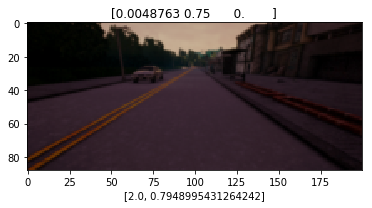

In [6]:
############# SANITY CHECK #############
frame = 125
plt.imshow(x_data_camera[frame])
plt.title(y_data[frame])
plt.xlabel([x_data_direction[frame], x_data_speed[frame]])

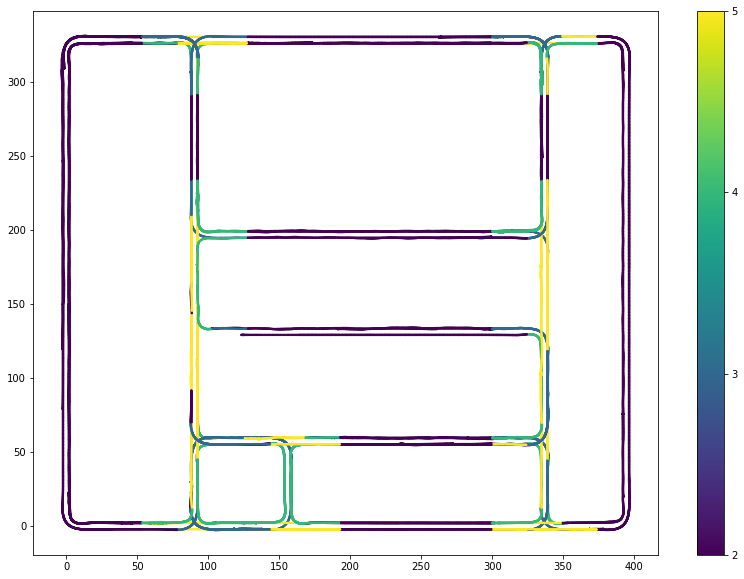

In [7]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(14, 10))
# cmap = mpl.colors.ListedColormap(['indigo', 'firebrick', 'royalblue', 'forestgreen'])
plt.scatter(pos_x, pos_y, 
           c=x_data_direction, s=2)
# plt.scatter(pos_x[range_start:range_end], pos_y[range_start:range_end], 
#             c=stop_traffic_lights[range_start:range_end])
plt.colorbar(ticks=[2, 3, 4, 5])

Text(0.5,1,'Brake Histogram')

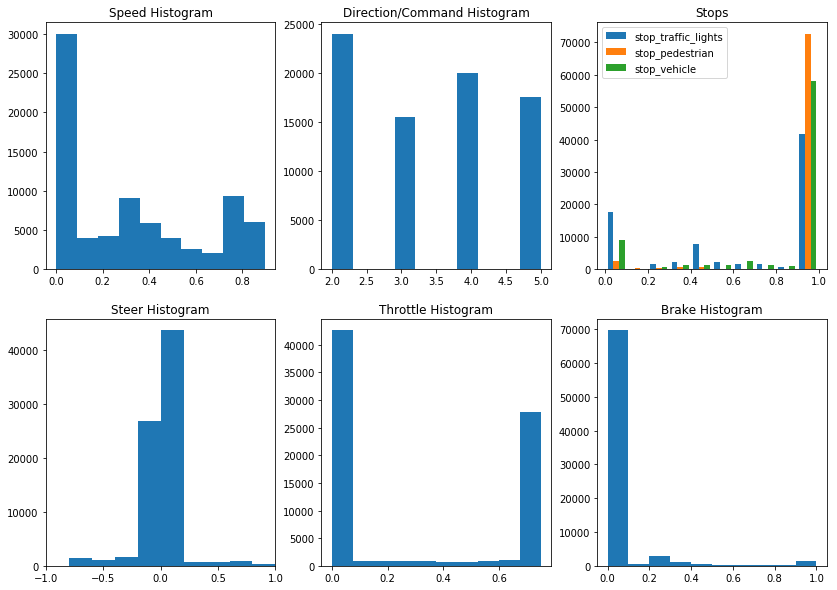

In [8]:
############# VISUALIZATION OF DATA DISTRIBUTION #############

fig, ax = plt.subplots(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.hist(x_data_speed, 10)
plt.title('Speed Histogram')

plt.subplot(2, 3, 2)
plt.hist(x_data_direction)
plt.title('Direction/Command Histogram')

plt.subplot(2, 3, 3)
plt.hist([stop_traffic_lights, stop_pedestrian, stop_vehicle])
plt.title('Stops')
plt.legend(['stop_traffic_lights', 'stop_pedestrian', 'stop_vehicle'])

plt.subplot(2, 3, 4)
plt.hist(y_data[:,0], 10)
plt.xlim([-1 ,1])
plt.title('Steer Histogram')

plt.subplot(2, 3, 5)
plt.hist(y_data[:,1], 10)
plt.title('Throttle Histogram')

plt.subplot(2, 3, 6)
plt.hist(y_data[:,2], 10)
plt.title('Brake Histogram')

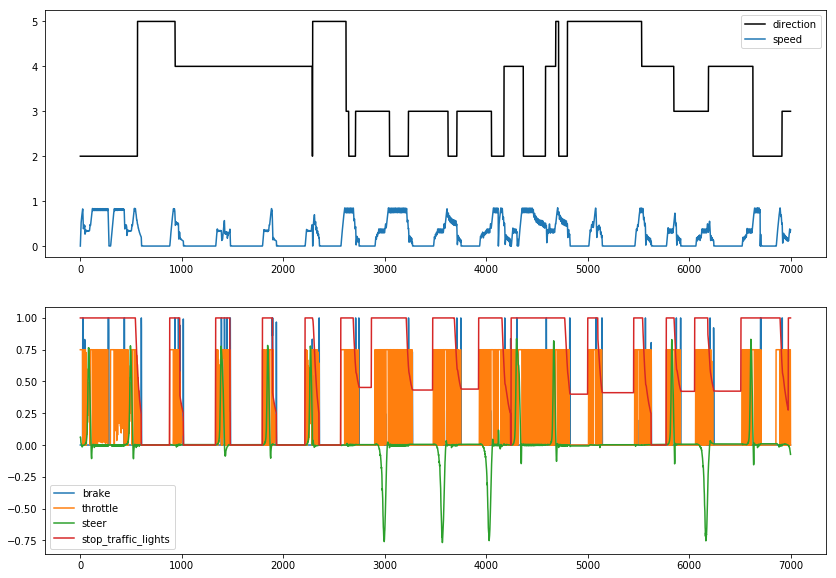

In [9]:
################## VISUALIZE CONTROL COMMANDS ######################
range_start, range_end = 0, 7000

# 2 - follow lane
# 3 - left
# 4 - right
# 5 - straight

fig, ax = plt.subplots(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(x_data_direction[range_start:range_end], '-k', label='direction')
plt.plot(x_data_speed[range_start:range_end], label='speed')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_data[range_start:range_end,2], label='brake')
plt.plot(y_data[range_start:range_end,1], label='throttle')
plt.plot(y_data[range_start:range_end,0], label='steer')
# plt.plot(x_data_direction[range_start:range_end], '-k', label='direction') 
plt.plot(stop_traffic_lights[range_start:range_end], label='stop_traffic_lights')
plt.legend()


Text(0.5,1,'[0.4224694073271305, 0.0]')

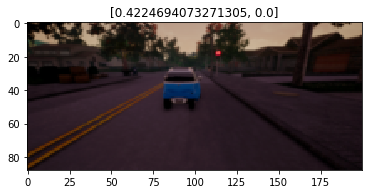

In [14]:
frame = 6000
plt.imshow(x_data_camera[frame])
plt.title([stop_traffic_lights[frame], stop_vehicle[frame]])

(array([1.6000e+01, 3.4000e+01, 6.7900e+02, 7.1100e+02, 5.2500e+02,
        5.0000e+02, 5.9700e+02, 8.2100e+02, 2.7370e+03, 1.2789e+04,
        1.8109e+04, 1.0180e+03, 3.9400e+02, 3.4200e+02, 2.9400e+02,
        3.5700e+02, 3.8600e+02, 4.7300e+02, 3.0500e+02, 4.7000e+01]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 20 Patch objects>)

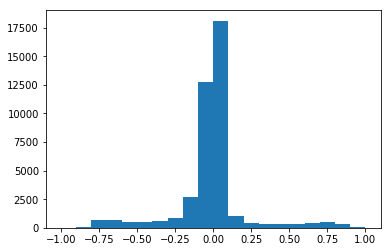

In [16]:
plt.hist(y_data[:, 0][stop_traffic_lights == 1], 20)

In [10]:
############# SAMPLING DATA AT SOME FPS #############
skip = True
if skip:
    FPS = 2
    x_data_camera = x_data_camera[::FPS]
    x_data_speed = x_data_speed[::FPS]
    x_data_direction = x_data_direction[::FPS]
    y_data = y_data[::FPS]
    
    stop_pedestrian     = stop_pedestrian[::FPS]
    stop_traffic_lights = stop_traffic_lights[::FPS]
    stop_vehicle        = stop_vehicle[::FPS]

    pos_x = pos_x[::FPS]
    pos_y = pos_y[::FPS]
    pos_z = pos_z[::FPS]
    print("Removed {:0.2f}% of frames.".format(1/FPS * 100))
else:
    print("Did not skip frames.")

Removed 50.00% of frames.


In [11]:
############# SPLIT DATA TO TRAINING AND TEST SETS #############
from sklearn.model_selection import ShuffleSplit, train_test_split

SPLIT_RATIO = 0.8
SHUFFLE = False

try:
    if not SHUFFLE:
        split = int(len(y_data) * SPLIT_RATIO)
        x_train_camera, x_test_camera = x_data_camera[:split], x_data_camera[split+1:]
        x_train_speed, x_test_speed = x_data_speed[:split], x_data_speed[split+1:]
        x_train_direction, x_test_direction = x_data_direction[:split], x_data_direction[split+1:]
        
        x_train_stop_pedestrian, x_test_stop_pedestrian = stop_pedestrian[:split], stop_pedestrian[split+1:]
        x_train_stop_traffic_lights, x_test_stop_traffic_lights = stop_traffic_lights[:split], stop_traffic_lights[split+1:]
        x_train_stop_vehicle, x_test_stop_vehicle = stop_vehicle[:split], stop_vehicle[split+1:]
        
        y_train, y_test = y_data[:split], y_data[split+1:]
    else:
        indices = np.arange(len(y_data))
        x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(indices, indices, test_size=0.25)
        
        x_train_camera = x_data_camera[x_train_ind, :, :, 0:3]
        x_test_camera = x_data_camera[x_test_ind, :, :, 0:3]
        
        x_train_speed = x_data_speed[x_train_ind]
        x_test_speed = x_data_speed[x_test_ind]
        
        x_train_direction = x_data_direction[x_train_ind]
        x_test_direction = x_data_direction[x_test_ind]
        
        
        y_train = y_data[y_train_ind, :]
        y_test = y_data[y_test_ind, :]
        del indices
        del x_train_ind, x_test_ind, y_train_ind, y_test_ind
except Error as E:
    print(E)
    print("x_data_* and y_data values are empty. Using previously stored values.")
    
print("Train Shape | x_train_camera:", x_train_camera.shape, "\t| x_train_camera:", x_train_speed.shape,
      "\t| y_train:", y_train.shape)
print(" Test Shape | x_test_camera:", x_test_camera.shape, "\t| x_test_speed:", x_test_speed.shape, 
      "\t| y_test:", y_test.shape)

Train Shape | x_train_camera: (30842, 88, 200, 3) 	| x_train_camera: (30842,) 	| y_train: (30842, 3)
 Test Shape | x_test_camera: (7710, 88, 200, 3) 	| x_test_speed: (7710,) 	| y_test: (7710, 3)


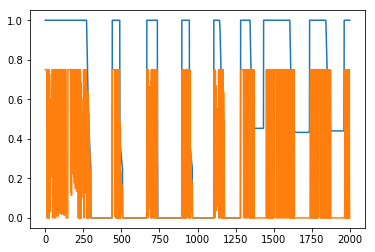

In [10]:
plt.plot(x_train_stop_traffic_lights[:2000])
# plt.plot(x_train_stop_pedestrian[:2000])
plt.plot(y_train[:2000, 1])
# plt.plot(x_train_stop_vehicle)

In [12]:
"""
Truth table:
vehicle ahead | red light     | final
    0         |      0        |   0
    0         |      1        |   1
    1         |      0        |   2
    1         |      1        |   3
    
final = red_light + vehicle_ahead * 2
"""
y_train = np.ceil((1 - x_train_stop_traffic_lights)) +  np.ceil((1 - x_train_stop_vehicle))*2
y_test = np.ceil((1 - x_test_stop_traffic_lights)) +  np.ceil((1 - x_test_stop_vehicle))*2

Text(0.5,1,'[0. 1. 0. 0.]')

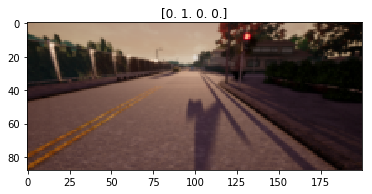

In [16]:
frame = 580
plt.imshow(x_train_camera[frame])
plt.title(y_train[frame])

30814/30842 [============================>.] - ETA: 0s

Images augmented 15907
28553/30842 [==========================>...] - ETA: 3s

Images augmented 30842


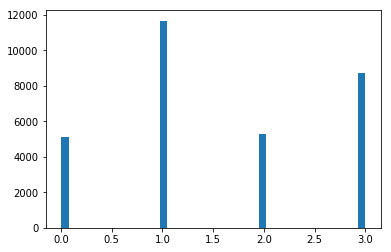

Images Augmented 30842


In [13]:
###### IMAGE AUGMENTATION #######

import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

st = lambda aug: iaa.Sometimes(0.4, aug)
oc = lambda aug: iaa.Sometimes(0.3, aug)
rl = lambda aug: iaa.Sometimes(0.09, aug)
seq = iaa.Sequential([
        rl(iaa.GaussianBlur((0, 1.5))), # blur images with a sigma between 0 and 1.5
        rl(iaa.SaltAndPepper((0, 0.1))),
        rl(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05), per_channel=0.5)), # add gaussian noise to images
        oc(iaa.Dropout((0.0, 0.10), per_channel=0.5)), # randomly remove up to X% of the pixels
        oc(iaa.CoarseDropout((0.0, 0.10), size_percent=(0.08, 0.2),per_channel=0.5)), # randomly remove up to X% of the pixels
        oc(iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -X to Y of original value)
        st(iaa.Multiply((0.10, 2.5), per_channel=0.2)), # change brightness of images (X-Y% of original value)
        rl(iaa.ContrastNormalization((0.5, 1.5), per_channel=0.5)), # improve or worsen the contrast
        #rl(iaa.Grayscale((0.0, 1))), # put grayscale
], random_order=False)

DATA_AUGMENT_MULTIPLIER = 1
N, IMG_H, IMG_W, IMG_CH = x_train_camera.shape
x_train_camera_aug = np.zeros((N*DATA_AUGMENT_MULTIPLIER, IMG_H, IMG_W, IMG_CH))
y_train_aug = np.zeros((N*DATA_AUGMENT_MULTIPLIER))

max_epoch = len(x_train_camera)


import random
def decision(probability):
    return random.random() <= probability

ctr = 0
images_augmented = 0

while ctr < len(x_train_camera_aug):
    progbar = Progbar(target=max_epoch, verbose=1)
    for i in range(max_epoch):
        if y_train[i] == 1: # red traffic
            probability = 0.7
        elif y_train[i] == 2:  # vehicle a head
            probability = 0.8
        elif y_train[i] == 3: # red traffic and vehicle ahead
            probability = 0.8
        else:
            probability = 0.2
    #         probability = 0
        if decision(probability):
            x_train_camera_aug[ctr] = seq.augment_images(x_train_camera[i:i+1, :, :, :])
            y_train_aug[ctr] =  y_train[i]
            images_augmented += 1
            ctr += 1
        if ctr >= len(x_train_camera_aug):
            break
        progbar.update(i)
    print("\n")
    print("Images augmented", images_augmented)
plt.hist(y_train_aug[:images_augmented], 40)
plt.show()
print("Images Augmented", images_augmented)

(30842, 88, 200, 3) (30842, 88, 200, 3)


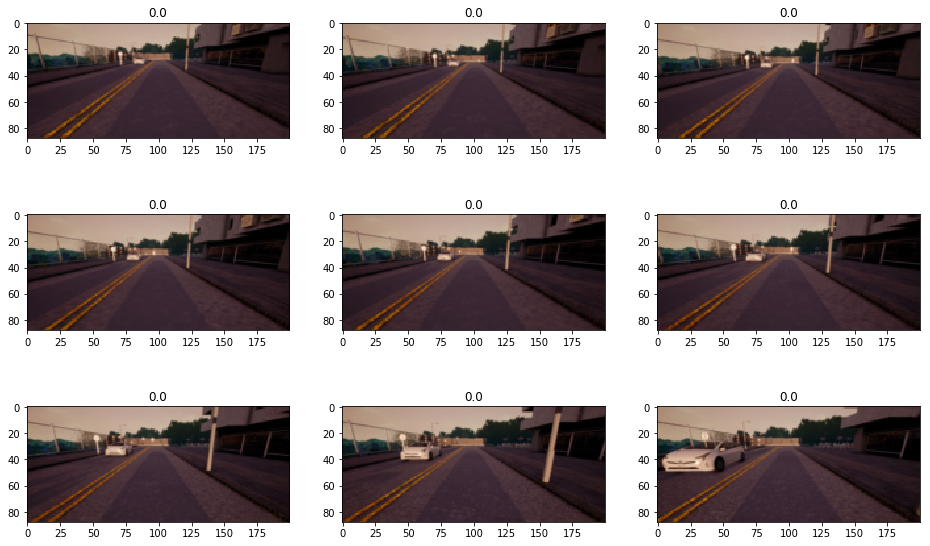

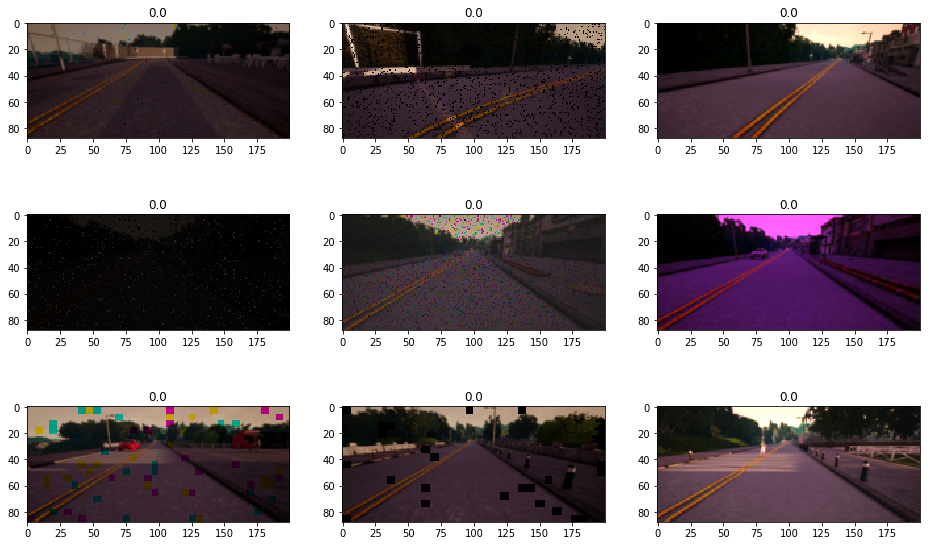

In [33]:
fig, ax = plt.subplots(figsize=(16, 10))

print(x_train_camera.shape, x_train_camera_aug.shape)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.title(y_train[i])
    plt.imshow(x_train_camera[i])
    
fig, ax = plt.subplots(figsize=(16, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.title(y_train_aug[i])
    plt.imshow(x_train_camera_aug[i]/255)  

In [14]:
x_train_camera = np.concatenate((x_train_camera, x_train_camera_aug))
y_train = np.concatenate((y_train, y_train_aug))

In [15]:
y_train.shape, y_train_aug.shape

((61684,), (30842,))

In [16]:
del x_train_camera_aug, x_data_camera

In [18]:
import keras

num_classes = 4

# input image dimensions
img_rows, img_cols, img_chnls = 88, 200, 3

x_train = x_train_camera.astype('float32')
x_test = x_test_camera.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_chnls)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_chnls)
input_shape = (img_rows, img_cols, img_chnls)

# convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(x_train_stop_traffic_lights == 1, num_classes)
# y_test = keras.utils.to_categorical(x_test_stop_traffic_lights == 1, num_classes)

print(np.unique(y_train))        
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

x_train shape: (61684, 88, 200, 3)
61684 train samples
7710 test samples
[0. 1. 2. 3.]


((61684, 88, 200, 3), (61684, 4), (7710, 88, 200, 3), (7710, 4))

In [19]:
del x_train_camera, x_test_camera

In [20]:
y_train_orig = np.argmax(y_train, axis=1)
y_test_orig = np.argmax(y_test, axis=1)


In [21]:
y_train[:, 1] = y_train[:, 1] + y_train[:, 3]
y_train[:, 2] = y_train[:, 2] + y_train[:, 3]
y_train = y_train[:, 0:3]
y_test[:, 1] = y_test[:, 1] + y_test[:, 3]
y_test[:, 2] = y_test[:, 2] + y_test[:, 3]
y_test = y_test[:, 0:3]

([array([43277.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 18407.]),
  array([27233.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 34451.]),
  array([38490.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 23194.])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 3 Lists of Patches objects>)

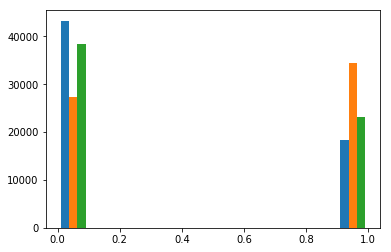

In [22]:
plt.hist(y_train)

In [24]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)
#                                     # (nothing gets printed in Jupyter, only if you run it standalone)
config.gpu_options.visible_device_list = '2'
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
# from keras.applications import ResNet50
# from keras.layers import Input, Dense, Flatten, Dropout
# from keras.models import Model

# input_tensor = Input(shape=(88, 200, 3))  # this assumes K.image_data_format() == 'channels_last'
# base_model = ResNet50(input_tensor=input_tensor,input_shape=(88, 200, 3),pooling=False,
#                       weights=None, include_top=False)
# x = base_model.output
# x = Flatten()(x)
# x = Dropout(0.5)(x)
# # safe = Dense(1, activation='sigmoid')(x)
# hazard_red_light = Dense(1, activation='sigmoid', name='hazard_red_light')(x)
# hazard_vehicle = Dense(1, activation='sigmoid', name='hazard_vehicle')(x)
# model = Model(inputs=base_model.input, 
#               outputs=[hazard_red_light, hazard_vehicle])

# adam = keras.optimizers.adam(lr=0.001, decay=1e-3)
# model.compile(optimizer=adam, 
#               loss='binary_crossentropy',
#               metrics=['accuracy'])


/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 88, 200, 3)   0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 94, 206, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 44, 100, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 44, 100, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [26]:
########### SET UP CALLBACKS ###########
from keras.callbacks import ModelCheckpoint, TensorBoard

# save weights
filepath_weights= "models/special/weights-epoch-{epoch:05d}.hdf5"
checkpoint_weights = ModelCheckpoint(filepath_weights, monitor='val_loss', verbose=1, 
                                     save_best_only=True, 
                                     save_weights_only=True, 
                                     period=25)

#save model
filepath_model="models/special/model-epoch-{epoch:05d}.hdf5"
checkpoint_model = ModelCheckpoint(filepath_model, verbose=1,  period=50)

tensorboard_callback = TensorBoard(log_dir='./logs/special/')
callbacks_list = [checkpoint_weights, checkpoint_model, tensorboard_callback]

In [81]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
metrics=['accuracy'])

batch_size = 32
epochs = 10

# history = model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#         validation_data=(x_test, y_test),
#          shuffle=True)

In [27]:
############# FIT NEURAL NETWORK #############
batch_size = 128
epochs = 200

history = model.fit(x_train, [y_train[:, 1], y_train[:, 2]], 
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, [y_test[:, 1], y_test[:, 2]]),
              shuffle=True,
              callbacks=callbacks_list)

Train on 61684 samples, validate on 7710 samples
Epoch 1/200
61684/61684 [==============================] - 221s 4ms/step - loss: 7.5618 - dense_1_loss: 0.5526 - dense_2_loss: 7.0092 - dense_1_acc: 0.8029 - dense_2_acc: 0.5005 - val_loss: 0.6450 - val_dense_1_loss: 0.3734 - val_dense_2_loss: 0.2717 - val_dense_1_acc: 0.8342 - val_dense_2_acc: 0.9195
Epoch 2/200
61684/61684 [==============================] - 200s 3ms/step - loss: 0.7057 - dense_1_loss: 0.3681 - dense_2_loss: 0.3376 - dense_1_acc: 0.8807 - dense_2_acc: 0.8974 - val_loss: 0.4050 - val_dense_1_loss: 0.2352 - val_dense_2_loss: 0.1697 - val_dense_1_acc: 0.9062 - val_dense_2_acc: 0.9468
Epoch 3/200
61684/61684 [==============================] - 200s 3ms/step - loss: 0.4990 - dense_1_loss: 0.2699 - dense_2_loss: 0.2291 - dense_1_acc: 0.9244 - dense_2_acc: 0.9360 - val_loss: 0.3374 - val_dense_1_loss: 0.1767 - val_dense_2_loss: 0.1607 - val_dense_1_acc: 0.9422 - val_dense_2_acc: 0.9516
Epoch 4/200
61684/61684 [=================

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


61684/61684 [==============================] - 202s 3ms/step - loss: 0.1267 - dense_1_loss: 0.0638 - dense_2_loss: 0.0630 - dense_1_acc: 0.9922 - dense_2_acc: 0.9938 - val_loss: 0.5624 - val_dense_1_loss: 0.2553 - val_dense_2_loss: 0.3071 - val_dense_1_acc: 0.9450 - val_dense_2_acc: 0.9527
Epoch 27/200
61684/61684 [==============================] - 201s 3ms/step - loss: 0.1319 - dense_1_loss: 0.0660 - dense_2_loss: 0.0659 - dense_1_acc: 0.9919 - dense_2_acc: 0.9924 - val_loss: 0.5457 - val_dense_1_loss: 0.2483 - val_dense_2_loss: 0.2974 - val_dense_1_acc: 0.9528 - val_dense_2_acc: 0.9556
Epoch 28/200
61684/61684 [==============================] - 201s 3ms/step - loss: 0.1213 - dense_1_loss: 0.0597 - dense_2_loss: 0.0615 - dense_1_acc: 0.9930 - dense_2_acc: 0.9942 - val_loss: 0.5645 - val_dense_1_loss: 0.2673 - val_dense_2_loss: 0.2972 - val_dense_1_acc: 0.9455 - val_dense_2_acc: 0.9603
Epoch 29/200
61684/61684 [==============================] - 201s 3ms/step - loss: 0.1181 - dense_1_lo

KeyboardInterrupt: 

In [82]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.2,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.2,
    shear_range=1.,  # set range for random shear
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format="channels_last",
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
batch_size = 32
epochs = 10
# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
history_aug = model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=len(x_train)//batch_size,
                    validation_data=(x_test, y_test),
                    workers=4)

Epoch 1/10
1927/1927 [==============================] - 97s 51ms/step - loss: 1.0148 - acc: 0.5823 - val_loss: 0.9346 - val_acc: 0.6780
Epoch 2/10
1927/1927 [==============================] - 95s 49ms/step - loss: 0.7837 - acc: 0.7102 - val_loss: 0.6270 - val_acc: 0.8059
Epoch 3/10
1927/1927 [==============================] - 95s 49ms/step - loss: 0.6471 - acc: 0.7694 - val_loss: 0.5126 - val_acc: 0.8573
Epoch 4/10
1927/1927 [==============================] - 95s 49ms/step - loss: 0.5804 - acc: 0.7940 - val_loss: 0.5113 - val_acc: 0.8551
Epoch 5/10
1927/1927 [==============================] - 95s 49ms/step - loss: 0.5387 - acc: 0.8115 - val_loss: 0.4327 - val_acc: 0.8912
Epoch 6/10
1927/1927 [==============================] - 95s 49ms/step - loss: 0.5098 - acc: 0.8235 - val_loss: 0.5544 - val_acc: 0.8162
Epoch 7/10
1927/1927 [==============================] - 95s 49ms/step - loss: 0.4846 - acc: 0.8334 - val_loss: 0.4844 - val_acc: 0.8529
Epoch 8/10
1927/1927 [==========================

In [24]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test), steps_per_epoch=len(x_train_camera)//batch_size,
                    epochs=epochs, verbose=1, workers=4)

Epoch 1/10
963/963 [==============================] - 136s 141ms/step - loss: 0.1362 - acc: 0.9586 - val_loss: 0.2464 - val_acc: 0.9209
Epoch 2/10
963/963 [==============================] - 136s 141ms/step - loss: 0.1251 - acc: 0.9616 - val_loss: 0.5042 - val_acc: 0.8669
Epoch 3/10
963/963 [==============================] - 136s 141ms/step - loss: 0.1158 - acc: 0.9644 - val_loss: 0.1773 - val_acc: 0.9463
Epoch 4/10
963/963 [==============================] - 136s 141ms/step - loss: 0.1045 - acc: 0.9675 - val_loss: 0.1968 - val_acc: 0.9475
Epoch 5/10
963/963 [==============================] - 137s 142ms/step - loss: 0.1017 - acc: 0.9690 - val_loss: 0.3083 - val_acc: 0.9021
Epoch 6/10
963/963 [==============================] - 136s 142ms/step - loss: 0.1044 - acc: 0.9695 - val_loss: 0.2603 - val_acc: 0.9113
Epoch 7/10
963/963 [==============================] - 136s 142ms/step - loss: 0.0946 - acc: 0.9720 - val_loss: 0.2164 - val_acc: 0.9337
Epoch 8/10
963/963 [============================

In [28]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()

NameError: name 'history' is not defined

In [60]:
# os.mkdir('models/special/')
model.save('models/special/stop_model_resnet.h5')

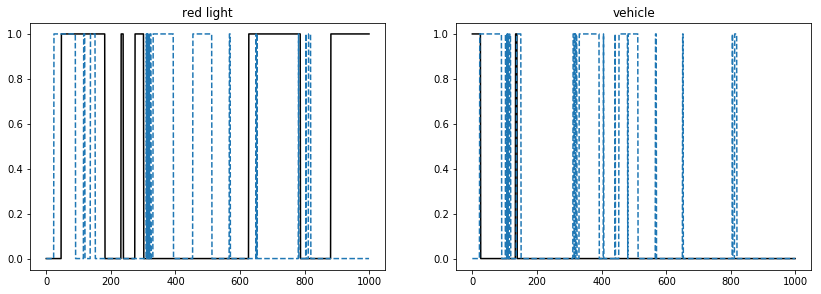

In [46]:
iters = 1000
pred = model.predict(x_test[:iters].reshape(iters, 88, 200, 3))
pred = np.array(pred).reshape(iters, 2)
fig, ax = plt.subplots(figsize=(14, 10))

labels = ['safe', 'red light', 'vehicle', 'red light + vehicle']
for i in range(2):
    plt.subplot(2, 2, i + 1)
    plt.plot(np.round(y_test[:iters, i+1]), 'k')
    plt.plot(np.round(pred[:, i]), '--')
    plt.title(labels[i+1])

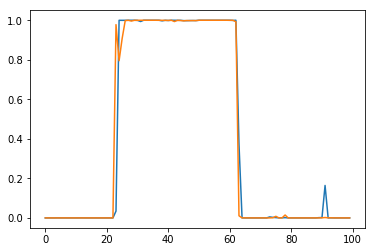

In [42]:
a = np.array(pred).reshape(iters, 2)
plt.plot(a)

(2,)


array([1., 1.], dtype=float32)

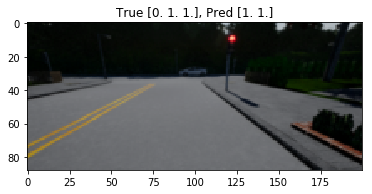

In [64]:
frame = np.random.randint(len(x_test))
pred = model.predict(x_test[frame].reshape(1, 88, 200, 3))
pred = np.array(pred).reshape(2)
print(pred.shape)

plt.imshow(x_test[frame])
plt.title("True {}, Pred {}".format(y_test[frame], np.round(pred)))
np.round(pred)